<a href="https://colab.research.google.com/github/NadiaFinzi/diplodatos-mumuki-equipo1/blob/main/Mumuki_E5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Mentoría MUMUKI
## **"Predicción de deserción en una plataforma educativa para aprender a programar".**

### Mentor

- Bulgarelli, Franco Leonardo

### Integrantes

- Finzi, Nadia
- Gherra C., Estefanía Inés
- Primo, Eugenia


# Bibliotecas, funciones e importación de datos

In [ ]:
# Librerías y configuraciones generales

# Esenciales
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import calendar

# Visualizacion
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.2 
plt.rcParams['grid.linestyle'] = "-."

%matplotlib inline
import seaborn as sns

from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

# Varios
import warnings
warnings.filterwarnings('ignore')
import itertools
import io

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from sklearn.cluster import AgglomerativeClustering

# Métricas
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_samples, silhouette_score




In [ ]:
# Definición de funciones y procedimientos propios

def graficar_boxplot(dataframe, columna, aclaracion_titulo, label_x, pie_grafico):
  fig = plt.figure(figsize=(8, 6))
  g = sns.boxenplot(data=dataframe, x= columna, color='salmon')
  plt.title('Boxplot de la variable ' + columna + aclaracion_titulo, fontsize=14, weight='bold')
  plt.ylabel("")
  plt.xlabel("\n" + label_x, fontsize=10)
  plt.annotate( pie_grafico, xy=(0.3, -0.25), xycoords='axes fraction', ha='right', va='center', fontsize=12)

def submissions_correctas(df):
  return df[(df["submission_status"] == "passed") | (df["submission_status"] == "passed_with_warnings")]

def submissions_incorrectas(df):
  return df[(df["submission_status"] == "failed") | (df["submission_status"] == "errored")]

def ordenar_y_agrupar(df):
  return df.sort_values(["student_uid", "submission_created_at"]).reset_index(drop=True).groupby(["student_uid", "exercise_new_id"])


# -------Funciones para gráficos-------

def plot_scatter_grid(x, y, exercises):
  row = 3
  col = 2
  i = 1 # inicia el conteo

  plt.figure(figsize = (20,15))
  for exercise in exercises:
    selector = estudiante_por_ejercicio[estudiante_por_ejercicio["exercise_new_id"] == exercise]
    plt.subplot(row, col, i)
    plt.title("Ejercicio " + str(exercise))
    sns.scatterplot(x = x, y = y, hue = 'cond_cant_ejer_resueltos', data = selector, facecolor="dodgerblue", edgecolor="k", palette=["blue", "red"])
    i += 1

  plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
  plt.show()

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# -------Funciones para armar modelos de regresión logística-------

def data_por_student(ids_ejercicios, imputar_con_constante, imputacion_nan):
  # Base con desagregación de ejercicios, por variables: intentos_incorrectos y tiempo_total.
  data = estudiante_por_ejercicio[estudiante_por_ejercicio.exercise_new_id.isin(ids_ejercicios)][["student_uid", "cond_cant_ejer_resueltos", "exercise_new_id", "intentos_incorrectos", "tiempo_total", "ultimo_estado"]]
  
  data["ultimo_estado"] = 0  # 0 = resolvió el ejercicio, sin importar en qué estado
  
  # Armamos la tabla pivot
  data["exercise_new_id"] = data["exercise_new_id"].astype(str)
  data_por_estudiante = pd.pivot_table(data, index= ["student_uid", "cond_cant_ejer_resueltos"], columns = ["exercise_new_id"], fill_value= np.nan)
  data_por_estudiante.columns = ['_'.join(col).strip() for col in data_por_estudiante.columns.values]
  
  # Llenamos el último estado con 1 si no resolvió cada ejercicio
  for col in data_por_estudiante.columns[data_por_estudiante.columns.str.contains("ultimo_estado")]:
    data_por_estudiante[col] = data_por_estudiante[col].fillna(1) 
  
  # Imputamos los NaN's en intentos incorrectos y en tiempo invertido de cada ejercicio
  if imputar_con_constante:
    data_por_estudiante.fillna(imputacion_nan, inplace = True) # Asigna la imputacion_nan para variables tiempo e intentos incorrectos
  else:
    for col in data_por_estudiante.columns: 
      data_por_estudiante[col] = np.where(data_por_estudiante[col].isna(), data_por_estudiante[col].max(), data_por_estudiante[col])
  return data_por_estudiante.reset_index()

def regresion_logistica(df, test_size, drop_ultimo_estado):
  X = df.drop(columns = ["cond_cant_ejer_resueltos"])
  if drop_ultimo_estado:
    X.drop(columns = X.columns[X.columns.str.contains("ultimo_estado")], inplace = True)
  y = df.cond_cant_ejer_resueltos
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  lr = LogisticRegression(random_state=0).fit(X_train, y_train)
  return X_train, X_test, y_train, y_test, lr.predict(X_train), lr.predict(X_test)

def construir_regresion_logistica(ids_ejercicios, test_size, imputar_con_constante, imputacion_nan, drop_ultimo_estado):
  return regresion_logistica(data_por_student(ids_ejercicios, imputar_con_constante, imputacion_nan), test_size, drop_ultimo_estado)

In [ ]:
# Apertura del dataset desde Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename)

drive = connect_to_drive()  # utilización de la función de apertura de archivos desde drive
df_submissions_0 = read_csv_from_drive(drive, '1oqeKaq164fYieUs6WODv53tF4hl7QY9N', 'df_submissions_python.csv') # el 2° parámetro es el id del archivo (terminación del link en drive)

# 1oqeKaq164fYieUs6WODv53tF4hl7QY9N
# [Fuente: https://colab.research.google.com/drive/1bPwYa_uumNJ7N6NazqSwLr-8dmiCaIj8]


# GENERACIÓN DE DF 

## Limpieza y filtrado

In [ ]:
# Corrección de nombres

df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'Más booleanos', 'El retorno del booleano' , df_submissions_0["exercise_name"])
df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'PIenso que así es más fácil', 'Pienso que así es más fácil', df_submissions_0["exercise_name"])

# Eliminamos "Calefones": 
df_submissions_0 = df_submissions_0[df_submissions_0["exercise_name"] != "Calefones"]

_orden_ejer = {"No tan distintos": 1, "Funciones, declaración": 2, "Funciones, uso": 3, "Probando funciones": 4, "Haciendo cuentas": 5, "Poniendo topes": 6, "¿Es par?": 7, "Libros de la buena memoria": 8, "Booleanos": 9, "Palabras, sólo palabras": 10, "Operando strings": 11, "¡GRITAR!": 12, "¿Y qué tal si...?":13, "¿De qué signo sos?": 14, "El retorno del booleano": 15, "Los premios": 16, "Tipos de datos": 17, "Datos de todo tipo": 18, 
        "Comprando Hardware": 19, "¿Me conviene?": 20, "Triangulos": 21, "Cuadrados": 22, "¿Está afinado?": 23, "¿Está cerca?": 24, "Cartelitos": 25, "Más Cartelitos": 26, "Cartelitos óptimos": 27, "Cara o ceca": 28, "¡Envido!": 29, "¡Quiero retruco!": 30, "¡Quiero vale cuatro!": 31,
        "¿Y el tablero?": 32, "Impresión por pantalla": 33, "Martin Fierro": 34, "¿Y los procedimientos?": 35, "¿Y el program?": 36, "Conversiones": 37, "El círculo de la vida": 38, "Pienso que así es más fácil": 39, "Esto no tiene valor": 40, "Variables globales": 41, "Volviéndonos ricos": 42, "¿Y esto cuánto vale?": 43}

# Mapeo del nombre de los ejercicios con su correspondiente orden dentro de la guía:
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_name"].map(_orden_ejer)
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_new_id"].apply(int)

# Eliminamos la columna del viejo id ya que no sera utilizada de aqui en adelante
df_submissions_0 = df_submissions_0.drop("exercise_eid", axis = 1)

# Eliminamos las columnas que no tienen datos
df_submissions_0 = df_submissions_0.drop("feedback", axis = 1)

# Pasamos la fecha a un formato datetime
df_submissions_0["submission_created_at"] = pd.to_datetime(df_submissions_0['submission_created_at'])

# Reemplazamos las listas vacías en test_results por NaN's
df_submissions_0["test_results"] = df_submissions_0.test_results.replace("[]", np.nan)

# Corregimos un outlier (failed que no compilaba y debería ser errored) a partir de result
df_submissions_0["submission_status"] = np.where((df_submissions_0.submission_status == "failed") & (df_submissions_0.result.notna()) , "errored", df_submissions_0.submission_status)

# Se filtran (excluyen por el momento) las pruebas: 
df_submissions = df_submissions_0[df_submissions_0["sid"] != -1]

# Se filtran (excluyen por el momento) status pending y aborted:
df_submissions = df_submissions[~df_submissions["submission_status"].isin(["pending", "aborted"])]

# Se filtran a estudiantes que tuvieron un único envío o son inválidos (por definición o porque su período de trabajo es mayor a un cuatrimestre):
df_submissions = df_submissions[~df_submissions["student_uid"].isin([75, 142, 361, 97, -1])]

# Se filtran ejercicios que fueron modificados y resueltos, en definitiva, por muy pocos estudiantes
df_submissions = df_submissions[df_submissions["exercise_new_id"] != 7]

# Obtenemos el periodo al que pertenecen l@s estudiantes para poder identificar los cursos: 
    # Creamos una columna que sólo indique el año: 
df_submissions["año"] = df_submissions["submission_created_at"].dt.year

    # Creamos una columna que sólo indique el cuatrimestre: 
df_submissions["cuatrimestre"] = np.where(df_submissions["submission_created_at"].dt.month.isin([ 5,  6,  7, 8]), "2 cuatr.","3 cuatr.")

    # Creamos una columna que sólo indique el día:
dias = {0: "1-Lunes", 1: "2-Martes", 2: "3-Miércoles", 3: "4-Jueves", 4: "5-Viernes", 5: "6-Sábado", 6: "7-Domingo"}
df_submissions["dia"] = df_submissions["submission_created_at"].dt.dayofweek
df_submissions["dia"].replace(dias, inplace =True)


## Cálculo de tiempos

In [ ]:
# Tiempo (en segundos) entre cada envío por estudiante:

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] =  df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_entre_envios"}).drop(columns = "index")
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_entre_envios.between(3, 1200)]

# Tiempo total
tiempo_recorrido_por_estudiante = intervalos_tiempo_por_estudiante.groupby("student_uid").tiempo_entre_envios.sum()

# Tiempo (en segundos) entre cada envío por estudiante y ejercicio:
tiempo_entre_envios_por_ejercicio = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).groupby(by=['student_uid', "exercise_new_id"]).submission_created_at.diff().dt.total_seconds().apply(np.ceil).reset_index()

# Agregamos la información del estudiante y del ejercicio en cuestión
tiempo_entre_envios_por_ejercicio = tiempo_entre_envios_por_ejercicio.fillna(0).rename(columns = {"submission_created_at": "tiempo_entre_intentos"}).drop(columns = ["index"])
tiempo_entre_envios_por_ejercicio[["student_uid", "exercise_new_id", "submission_created_at"]] = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).reset_index()[["student_uid", "exercise_new_id", "submission_created_at"]]

tiempo_entre_envios_por_ejercicio["tiempo_intento_modificado"] = tiempo_entre_envios_por_ejercicio.tiempo_entre_intentos.apply(lambda row: 0 if row > 1200 else row)

# Nuevo tiempo total (en segundos) para cada estudiante en cada ejercicio
tiempo_total_por_ejercicio_2 = tiempo_entre_envios_por_ejercicio.groupby(by=['student_uid', "exercise_new_id"]).agg({"tiempo_intento_modificado": "sum", "submission_created_at": "nunique"}).reset_index()
tiempo_total_por_ejercicio_2.rename(columns = {"tiempo_intento_modificado": "tiempo_total", "submission_created_at": "intentos_totales"}, inplace = True)
tiempo_total_por_ejercicio_2

,student_uid,exercise_new_id,tiempo_total,intentos_totales
0,76,2,0.0,1
1,76,3,0.0,2
2,76,6,0.0,1
3,76,9,915.0,5
4,76,10,20.0,2
...,...,...,...,...
7810,359,43,0.0,1
7811,362,21,87.0,3
7812,363,25,61.0,3
7813,363,26,151.0,4


## Construcción de nuevo df con métricas por estudiante

In [ ]:
# Por cada estudiante obtenemos la cantidad de ejercicios con status passed o passed_with_warnings que realizó:
#filtro_status = submissions_correctas(df_submissions)
filtro_status = df_submissions
group_ejer = filtro_status[["student_uid", "exercise_new_id"]]
group_ejer = group_ejer.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_resueltos'})

# Creamos la columna de desercion:
# Regla de decision: 
criterio_por_ejercicios_resueltos = group_ejer["ejercicios_resueltos"].quantile(0.25)
#criterio_por_ejercicios_resueltos = 30

df_cond_ejer = group_ejer.copy()
df_cond_ejer["cond_cant_ejer_resueltos"] = np.where(df_cond_ejer["ejercicios_resueltos"] < criterio_por_ejercicios_resueltos, 1, 0)

df_cond_ejer = df_cond_ejer.reset_index() 

# -------

filtro_fallidos = submissions_incorrectas(df_submissions)

# Envíos fallidos por estudiante, por guía/lección, y por ejercicio.

df_fallidos = filtro_fallidos.groupby(['student_uid','exercise_new_id'])['sid'].count().reset_index().rename(columns = {'sid': 'intentos_fallidos_max_ejer'}).sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False])

# Regla de decisión: 
criterio_por_intentos_fallidos = df_fallidos.sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False]).drop_duplicates("student_uid")["intentos_fallidos_max_ejer"].quantile(0.75)

# Creamos la columna de deserción:
df_cond_fallos_ejer = df_fallidos.copy()[["student_uid", "intentos_fallidos_max_ejer"]]
df_cond_fallos_ejer["cond_fallos_ejer"] = np.where(df_fallidos["intentos_fallidos_max_ejer"] > criterio_por_intentos_fallidos, 1, 0)

df_cond_fallos_ejer = df_cond_fallos_ejer.sort_values('intentos_fallidos_max_ejer', ascending = False).drop_duplicates('student_uid')

# -------

# Cantidad de ejercicios intentados (en cualquier estado) por persona

group_ejer_int = df_submissions[["student_uid", "exercise_new_id"]]
group_ejer_int = group_ejer_int.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_totales'})
group_ejer_int = group_ejer_int.reset_index()

# -------

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] = df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_total_invertido"}).drop(columns = "index")

# Nos quedamos con los intervalos de tiempo que se hayan realizado entre 3 segundos y 20 minutos
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_total_invertido.between(3, 1200)]
df_cond_tiempo_ejer = intervalos_tiempo_por_estudiante.groupby('student_uid', as_index=False).sum()



# DF con las condiciones obtenidas a partir de las metricas de deserción

df_condiciones = df_cond_ejer.merge(df_cond_tiempo_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(df_cond_fallos_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(group_ejer_int, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.fillna(0)
df_condiciones['ejercicios_fallidos'] = df_condiciones.ejercicios_totales - df_condiciones.ejercicios_resueltos

# -------
df_condiciones['tiempo_prom_por_ej_correcto'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_resueltos
df_condiciones['tiempo_prom_por_ejercicio'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_totales

# Regla de decisión: 
criterio_por_tiempo_por_ejercicio = df_condiciones["tiempo_prom_por_ejercicio"].quantile(0.75)

df_condiciones["cond_tiempo_prom_ejer"] = np.where(df_condiciones["tiempo_prom_por_ejercicio"] > criterio_por_tiempo_por_ejercicio, 1, 0)

# -------

intentos_totales = df_submissions.groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_totales"}) # envios totales por persona
intentos_incorrectos = submissions_incorrectas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_incorrectos"}) # envios fallidos por persona
intentos_correctos = submissions_correctas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_correctos"}) # envios correctos por persona

# Agregamos las columnas con cantidad de intentos totales y distinguidos por estado
df_condiciones = df_condiciones.merge(intentos_totales, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_incorrectos, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_correctos, on = "student_uid", how = "outer")

df_condiciones = df_condiciones[["student_uid", "ejercicios_totales", "ejercicios_fallidos","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_totales","intentos_incorrectos","intentos_correctos", "intentos_fallidos_max_ejer","cond_fallos_ejer","tiempo_total_invertido","tiempo_prom_por_ej_correcto","tiempo_prom_por_ejercicio","cond_tiempo_prom_ejer"]]
df_condiciones

,student_uid,ejercicios_totales,ejercicios_fallidos,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_totales,intentos_incorrectos,intentos_correctos,intentos_fallidos_max_ejer,cond_fallos_ejer,tiempo_total_invertido,tiempo_prom_por_ej_correcto,tiempo_prom_por_ejercicio,cond_tiempo_prom_ejer
0,76,30,0,30,0,60,29.0,31.0,7.0,0.0,7991.0,266.366667,266.366667,0
1,77,33,0,33,0,122,85.0,37.0,30.0,0.0,10945.0,331.666667,331.666667,0
2,78,5,0,5,1,28,25.0,3.0,11.0,0.0,3247.0,649.400000,649.400000,1
3,79,18,0,18,1,64,47.0,17.0,10.0,0.0,4464.0,248.000000,248.000000,0
4,80,13,0,13,1,91,80.0,11.0,26.0,0.0,7091.0,545.461538,545.461538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,355,8,0,8,1,15,11.0,4.0,4.0,0.0,2020.0,252.500000,252.500000,0
277,358,1,0,1,1,6,5.0,1.0,5.0,0.0,96.0,96.000000,96.000000,0
278,359,13,0,13,1,31,19.0,12.0,6.0,0.0,4322.0,332.461538,332.461538,0
279,362,1,0,1,1,3,3.0,NaN,3.0,0.0,87.0,87.000000,87.000000,0


## Construcción de nuevo df con métricas por estudiante y ejercicio

In [ ]:
ultimo_estado = ordenar_y_agrupar(df_submissions).tail(1)[["student_uid", "exercise_new_id", "submission_status"]]
ultimo_estado = ultimo_estado.rename(columns={"submission_status": "ultimo_estado"})

#Tablas por estudiante y ejercicio con cantidad de intentos en cada estado:
correctos = ordenar_y_agrupar(submissions_correctas(df_submissions)).agg({"sid": "count", "submission_created_at": "min"})
correctos = correctos.rename(columns = {"sid": "intentos_correctos", "submission_created_at": "fecha_primer_correcto"})

incorrectos = ordenar_y_agrupar(submissions_incorrectas(df_submissions)).agg({"sid": "count", "submission_created_at": "max"})
incorrectos = incorrectos.rename(columns = {"sid": "intentos_incorrectos", "submission_created_at": "fecha_ultimo_incorrecto"})

estudiante_por_ejercicio = pd.concat([correctos, incorrectos], axis = 1).reset_index()

#-----

estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, ultimo_estado)
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, tiempo_total_por_ejercicio_2)

#-----

# Reordenamos las columnas
estudiante_por_ejercicio = estudiante_por_ejercicio[["student_uid", "exercise_new_id", "ultimo_estado", "intentos_totales", "intentos_correctos", "intentos_incorrectos", "tiempo_total", "fecha_primer_correcto", "fecha_ultimo_incorrecto"]]
estudiante_por_ejercicio

#-----

# Agregamos columnas de condiciones para tener más info y distinguir deserción
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, df_condiciones[["student_uid", "ejercicios_totales","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_fallidos_max_ejer"]], on = "student_uid", how = "left")
estudiante_por_ejercicio.fillna(0, inplace = True)

estudiante_por_ejercicio.head()


,student_uid,exercise_new_id,ultimo_estado,intentos_totales,intentos_correctos,intentos_incorrectos,tiempo_total,fecha_primer_correcto,fecha_ultimo_incorrecto,ejercicios_totales,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_fallidos_max_ejer
0,76,2,passed,1,1.0,0.0,0.0,2019-08-30 13:17:17.700000,0,30,30,0,7.0
1,76,3,passed,2,1.0,1.0,0.0,2019-09-10 20:00:32.156000,2019-08-30 13:40:26.023000,30,30,0,7.0
2,76,6,passed,1,1.0,0.0,0.0,2019-09-23 12:24:41.746000,0,30,30,0,7.0
3,76,9,passed,5,1.0,4.0,915.0,2019-09-23 13:05:45.340000,2019-09-23 13:04:41.529000,30,30,0,7.0
4,76,10,passed,2,1.0,1.0,20.0,2019-09-23 13:08:05.815000,2019-09-23 13:07:46.418000,30,30,0,7.0


# ENTREGA 5

Partimos del dataframe utilizado para el modelo que nos dio mejores resultados, en terminos de las metricas definidas en la entrega anterior. 

In [ ]:
df_1_20_seleccionado = data_por_student(list(range(1,21)), imputar_con_constante = False, imputacion_nan = 0)
df_1_20_seleccionado = df_1_20_seleccionado.drop(["intentos_incorrectos_1", "intentos_incorrectos_8", "intentos_incorrectos_18", "intentos_incorrectos_20", "tiempo_total_1", "tiempo_total_8", "tiempo_total_18", "tiempo_total_20"], axis = 1)

In [ ]:
df_cluster_inicial = df_1_20_seleccionado.drop("cond_cant_ejer_resueltos", axis = 1)
df_cluster = df_1_20_seleccionado.drop(["cond_cant_ejer_resueltos", "student_uid"], axis = 1)
df_cluster

,intentos_incorrectos_10,intentos_incorrectos_11,intentos_incorrectos_12,intentos_incorrectos_13,intentos_incorrectos_14,intentos_incorrectos_15,intentos_incorrectos_16,intentos_incorrectos_19,intentos_incorrectos_2,intentos_incorrectos_3,intentos_incorrectos_6,intentos_incorrectos_9,tiempo_total_10,tiempo_total_11,tiempo_total_12,tiempo_total_13,tiempo_total_14,tiempo_total_15,tiempo_total_16,tiempo_total_19,tiempo_total_2,tiempo_total_3,tiempo_total_6,tiempo_total_9,ultimo_estado_1,ultimo_estado_10,ultimo_estado_11,ultimo_estado_12,ultimo_estado_13,ultimo_estado_14,ultimo_estado_15,ultimo_estado_16,ultimo_estado_18,ultimo_estado_19,ultimo_estado_2,ultimo_estado_20,ultimo_estado_3,ultimo_estado_6,ultimo_estado_8,ultimo_estado_9
0,1.0,1.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,4.0,20.0,60.0,0.0,12.0,0.0,1085.0,0.0,0.0,0.0,0.0,0.0,915.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,14.0,1.0,0.0,0.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,1.0,522.0,10.0,0.0,0.0,141.0,172.0,201.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,88.0,91.0,65.0,33.0,61.0,74.0,77.0,4.0,2.0,7.0,1.0,11.0,5592.0,11918.0,4549.0,1646.0,4343.0,5073.0,3749.0,227.0,42.0,694.0,116.0,941.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10.0,6.0,4.0,0.0,1.0,9.0,1.0,0.0,0.0,1.0,1.0,2.0,700.0,140.0,133.0,0.0,8.0,393.0,37.0,0.0,0.0,67.0,47.0,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,7.0,13.0,65.0,33.0,61.0,74.0,77.0,27.0,5.0,0.0,6.0,26.0,445.0,898.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,249.0,0.0,216.0,1014.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,15.0,26.0,65.0,33.0,61.0,74.0,77.0,27.0,0.0,3.0,8.0,8.0,751.0,912.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,0.0,86.0,303.0,772.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276,0.0,91.0,65.0,33.0,61.0,74.0,77.0,2.0,33.0,44.0,53.0,0.0,0.0,11918.0,4549.0,1646.0,4343.0,5073.0,3749.0,17.0,1857.0,3319.0,2879.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
277,88.0,5.0,65.0,33.0,61.0,74.0,77.0,27.0,33.0,44.0,53.0,50.0,5592.0,98.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,1857.0,3319.0,2879.0,2759.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## K-Means

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

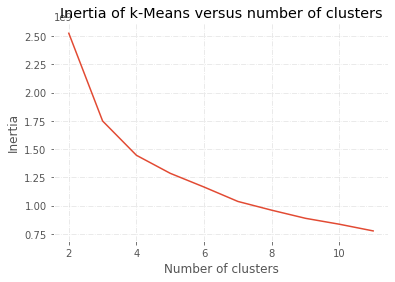

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_cluster).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Probaremos un método **k-means** con dos clusters ya que esta cantidad es la que hipotetizamos como adecuada para nuestro problema. Recordemos que estamos trabajando con dos perfiles de estudiantes: *desertores* y *no desertores*.

Para analizar los resultados del método k-means, observamos el gráfico del codo o de inercia para cada número de clusters posibles.  En particular, queríamos verificar si la cantidad hipotetizada de "2" clusters podría aceptarse como "óptima". 

Con el gráfico no vemos que la misma sea errónea, pero consideramos analizar opciones con mayor número de clusters: "3" ó "4". 

Para poder comparar estas opciones, realizamos el gráfico de siluetas para cada caso. 

### Para 3 clusters

In [ ]:
# Número de clusters buscado: desertores y no desertores
n_clust = 3

km = KMeans(n_clusters=n_clust, random_state = 5)
km.fit(df_cluster) # Se utilizan variables de intentos y tiempo, ambos por ejercicio

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  1749028913.5996733


#### Dispersión

In [ ]:
variables = df_cluster.columns

#Eligo dos números entre 0 y de 39

var_1="tiempo_total_9"
var_2="intentos_incorrectos_9"

kmean_clusters = go.Scatter(x=df_cluster[var_1], y=df_cluster[var_2],
                           mode='markers',
                        text=df_cluster_inicial.loc[:,'student_uid'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )
"""
crack =go.Scatter(x=df_skills.loc[df_cluster,var_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')
"""
data=[kmean_clusters]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=var_1),
                yaxis=dict(title=var_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

In [ ]:
df_cluster_encontrados = df_cluster.copy()
df_cluster_encontrados['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotras forzamos la cantidad')

Kmeans encontró:  3 clusters, nosotras forzamos la cantidad


#### Silueta

In [ ]:
skill_sets = [['tiempo_total_9', 'intentos_incorrectos_10'], ['tiempo_total_10', 'intentos_incorrectos_9']]

Para n_clust = 3 El silhouette_score promedio es : 0.6659100462972223


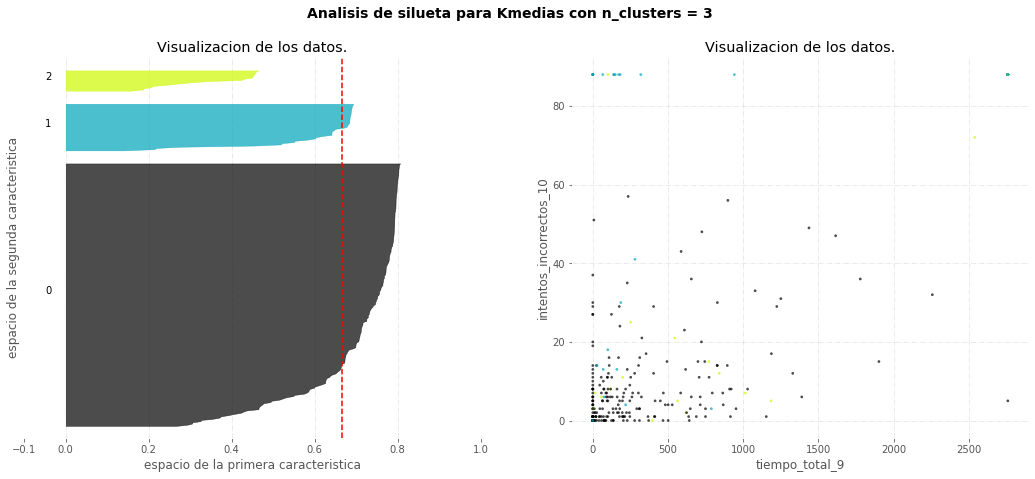

Para n_clust = 3 El silhouette_score promedio es : 0.6659100462972223


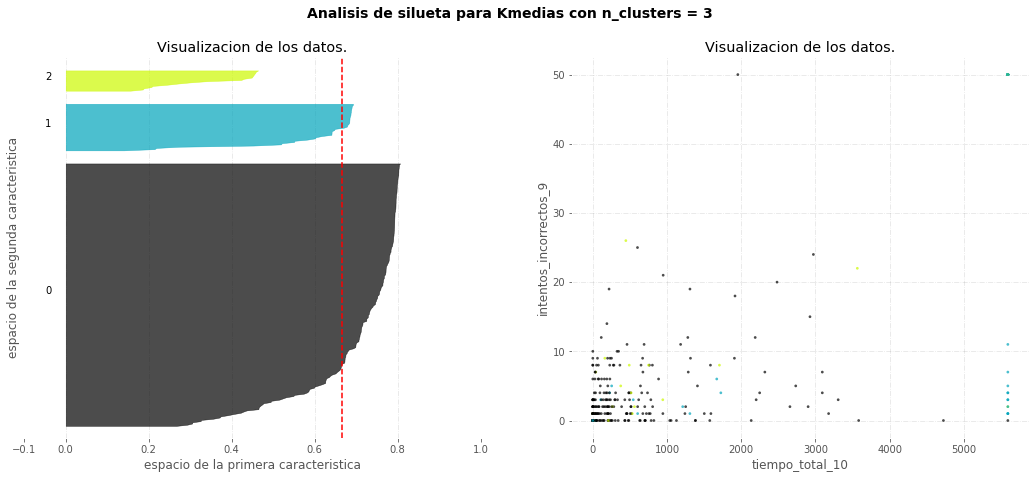

In [ ]:
cluster_labels = km.fit_predict(df_cluster)
for sset in skill_sets:
  skill_1 = sset[0]
  skill_2 = sset[1]
 
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(df_cluster) + (n_clust + 1) * 10])

  sse = km.inertia_
  silhouette_avg = silhouette_score(df_cluster, cluster_labels)
  print("Para n_clust =", n_clust, "El silhouette_score promedio es :", silhouette_avg)

  # Calculamos el score para cada sample
  sample_silhouette_values = silhouette_samples(df_cluster, cluster_labels)

  y_lower = 10
  for i in range(n_clust):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clust)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("Visualizacion de los datos.")
  ax1.set_xlabel("espacio de la primera caracteristica")
  ax1.set_ylabel("espacio de la segunda caracteristica")


  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
  ax2.scatter(df_cluster.loc[:, skill_1].values, df_cluster.loc[:, skill_2].values, marker='.', s=30, lw=0, alpha=0.7,
              c=colors, edgecolor='k')

  # No esta el labeling de los clusters

  ax2.set_title("Visualizacion de los datos.")
  ax2.set_xlabel(skill_1)
  ax2.set_ylabel(skill_2)

  plt.suptitle(("Analisis de silueta para Kmedias "
                "con n_clusters = %d" % n_clust),
                fontsize=14, fontweight='bold')
  #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

  plt.show()

### Para 2 clusters

In [ ]:
# Número de clusters buscado: desertores y no desertores
n_clust = 2

km = KMeans(n_clusters=n_clust, random_state = 5)
km.fit(df_cluster) # Se utilizan variables de intentos y tiempo, ambos por ejercicio

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  2525772201.9956956


#### Dispersión

In [ ]:
variables = df_cluster.columns

#Eligo dos números entre 0 y de 39

var_1="tiempo_total_9"
var_2="intentos_incorrectos_9"

kmean_clusters = go.Scatter(x=df_cluster[var_1], y=df_cluster[var_2],
                           mode='markers',
                        text=df_cluster_inicial.loc[:,'student_uid'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[kmean_clusters]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=var_1),
                yaxis=dict(title=var_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

In [ ]:
df_cluster_encontrados = df_cluster.copy()
df_cluster_encontrados['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotras forzamos la cantidad')

Kmeans encontró:  2 clusters, nosotras forzamos la cantidad


#### Silueta

In [ ]:
skill_sets = [['tiempo_total_9', 'intentos_incorrectos_10'], ['tiempo_total_10', 'intentos_incorrectos_9']]

Para n_clust = 2 El silhouette_score promedio es : 0.7605955163477567


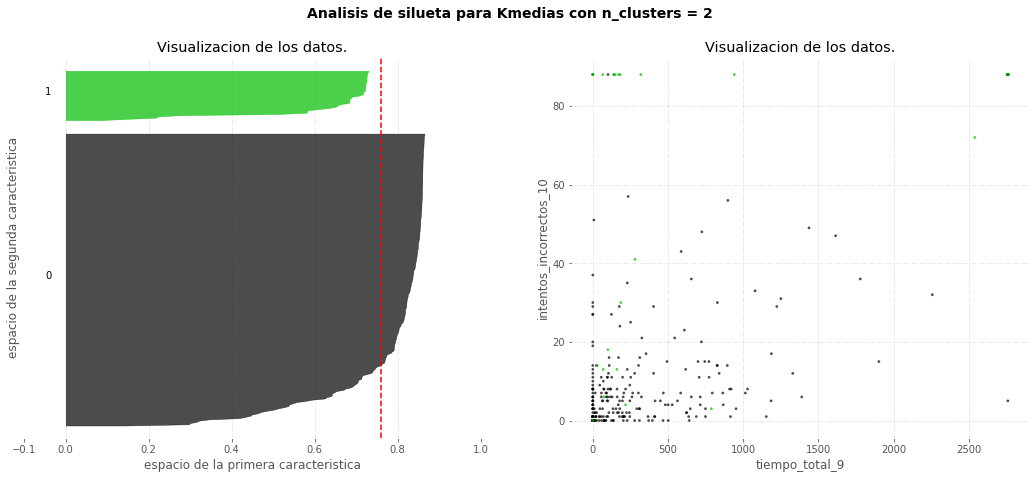

Para n_clust = 2 El silhouette_score promedio es : 0.7605955163477567


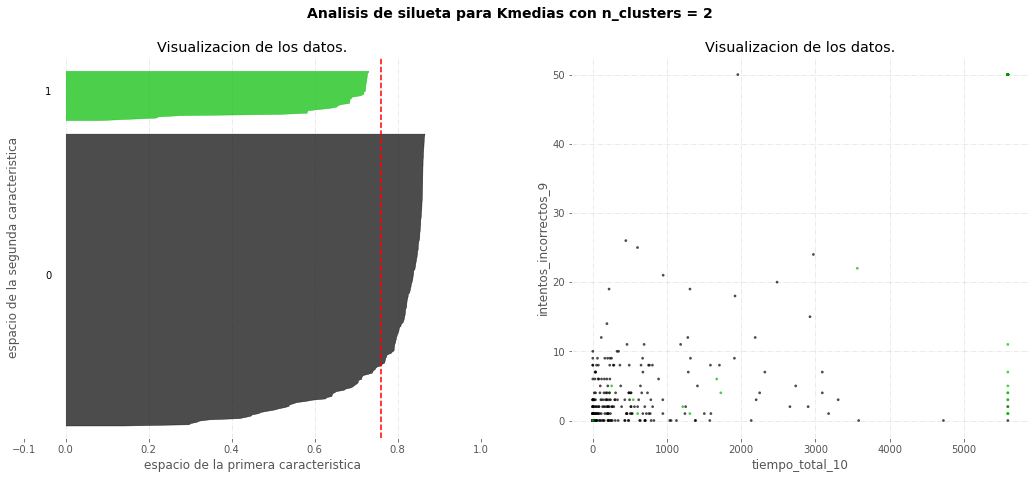

In [ ]:
cluster_labels = km.fit_predict(df_cluster)
for sset in skill_sets:
  skill_1 = sset[0]
  skill_2 = sset[1]
 
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(df_cluster) + (n_clust + 1) * 10])

  sse = km.inertia_
  silhouette_avg = silhouette_score(df_cluster, cluster_labels)
  print("Para n_clust =", n_clust, "El silhouette_score promedio es :", silhouette_avg)

  # Calculamos el score para cada sample
  sample_silhouette_values = silhouette_samples(df_cluster, cluster_labels)

  y_lower = 10
  for i in range(n_clust):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clust)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("Visualizacion de los datos.")
  ax1.set_xlabel("espacio de la primera caracteristica")
  ax1.set_ylabel("espacio de la segunda caracteristica")


  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
  ax2.scatter(df_cluster.loc[:, skill_1].values, df_cluster.loc[:, skill_2].values, marker='.', s=30, lw=0, alpha=0.7,
              c=colors, edgecolor='k')

  # No esta el labeling de los clusters

  ax2.set_title("Visualizacion de los datos.")
  ax2.set_xlabel(skill_1)
  ax2.set_ylabel(skill_2)

  plt.suptitle(("Analisis de silueta para Kmedias "
                "con n_clusters = %d" % n_clust),
                fontsize=14, fontweight='bold')
  #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

  plt.show()

### Conclusión

Lo que concluimos es que para 3 y 4 clusters (no graficamos este último caso para economizar espacio), hay siluetas que se distancian bastante del promedio general, lo cual no es un buen indicador de homogeneidad dentro del cluster. Esto no sucede en el caso de 2 clusters, por lo cual lo consideramos un valor óptimo aplicando el método k-means.

### Comparación del resultado de clustering y perfiles observados

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

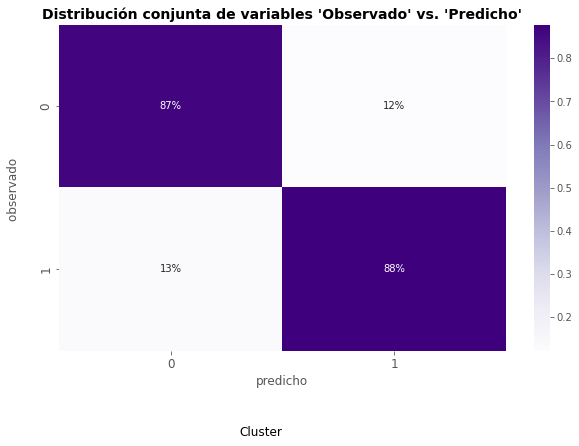

In [ ]:
df_kmeans = pd.DataFrame()
df_kmeans["predicho"] = pd.Series(cluster_labels)
df_kmeans["observado"] = df_1_20_seleccionado["cond_cant_ejer_resueltos"]

fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df_kmeans['observado'],
    df_kmeans['predicho'],
    normalize='columns'
)
sns.heatmap(exp, annot=True, fmt='0.0%', cmap='Purples')
plt.xlabel("predicho")
plt.ylabel("observado \n")
plt.title("Distribución conjunta de variables 'Observado' vs. 'Predicho'", fontsize=14, weight='bold')
plt.annotate(
    'Cluster', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Jerárquico

In [ ]:
cluster = AgglomerativeClustering(affinity='cityblock', linkage= 'average', n_clusters= None, distance_threshold=21000)
cluster.fit(df_cluster)

clusters2 = cluster.labels_
cluster_centers = cluster.n_clusters_

labels_unique = np.unique(clusters2)
n_clusters = len(labels_unique)

print("Cantidad de clusters encontrados: %d" % n_clusters)

Cantidad de clusters encontrados: 2


In [ ]:
data=[]
complete_clusters = go.Scatter(x=df_cluster[var_1], y=df_cluster[var_2],
                           mode='markers',
                        text=df_cluster_inicial.loc[:,'student_uid'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

data=[complete_clusters]

layout = go.Layout(title="Complete CityBlock Agglomerative",titlefont=dict(size=20),
                xaxis=dict(title=var_1),
                yaxis=dict(title=var_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")

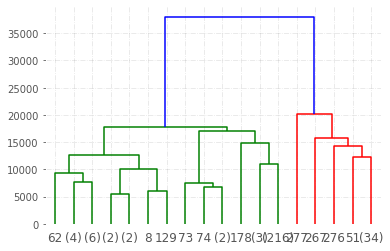

In [ ]:
plot_dendrogram(cluster, truncate_mode='level', p=4)

### Conclusión

Por otro lado, aplicamos el método jerárquico con vinculación promedio, y utilizamos el gráfico "dendrograma" para determinar la cantidad óptima de clusters. En este sentido uno debe "detener la fusión de conglomerados cuando los grupos que se han de unir están a una distancia significaticamente mayor de los que previamente se han fusionado" (Jiménez E., Aldas Manzano E., 2005)*. 

Tal como se observa en el gráfico, esto sucede cuando se fusionan los grupos determinando dos grandes conglomerados (el grupo "rojo" y el grupo "verde").

Es decir, seleccionamos como cantidad óptima también en este caso 2 clusters (y se confirma nuestra hipótesis inicial).

Dado esta observación gráfica, definimos como treshold el valor 21.000 y en consecuencia el método jerárquico arrojó como óptima, la cantidad 2.


---


*Jiménez E. Aldas Manzano E. (2005). Análisis multivariante aplicado. 

### Comparación del resultado de clustering y perfiles observados

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

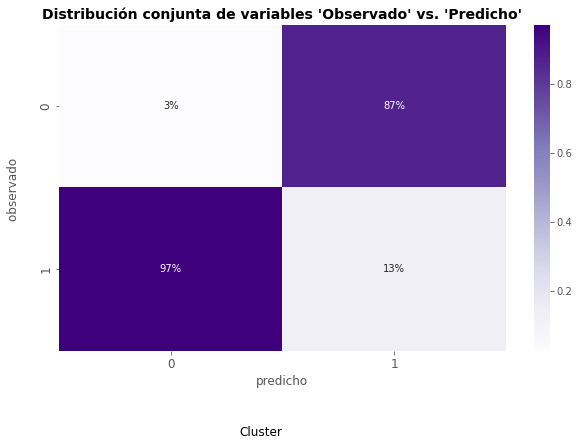

In [ ]:
df_jerarquico = pd.DataFrame()
df_jerarquico["predicho"] = pd.Series(clusters2)
df_jerarquico["observado"] = df_1_20_seleccionado["cond_cant_ejer_resueltos"]

fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df_jerarquico['observado'],
    df_jerarquico['predicho'],
    normalize='columns'
)
sns.heatmap(exp, annot=True, fmt='0.0%', cmap='Purples')
plt.xlabel("predicho")
plt.ylabel("observado \n")
plt.title("Distribución conjunta de variables 'Observado' vs. 'Predicho'", fontsize=14, weight='bold')
plt.annotate(
    'Cluster', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Conclusión general

Con los heatmap realizados para los métodos utilizados: *K-means* y *Jerárquico*, realizamos la evaluación o comparación de las etiquetas obtenidas por las clusterizaciones (valores predichos) versus los perfiles que contábamos originalmente (valores observados de desertores y no desertores). 

Lo que podemos observar es que para ambos métodos hay una relación estrecha entre los clusters obtenidos y los perfiles de deserción.

En particular con el método K-means, el 86% de los estudiantes del cluster  "1" se corresponden con el perfil desertor (valor = 1 observado), mientras que en el cluster "0", vemos que un 87% de sus estudiantes se corresponden con el perfil no desertor (valor = 0 observado).

En el método jerárquico, el cluster “1” tiene 87% de estudiantes con perfil desertor, y el cluster “0” tiene 97% de estudiantes con perfil no desertor.

--

Por último, notamos que aplicando clustering utilizamos la información de todas las variables analizadas (intentos_incorrectos y tiempos_totales_invertidos, en cada ejercicio) para asignar los estudiantes a los clusters 0 y 1. Con esto, y mediante el gráfico *heatmap*, pudimos visibilizar la relación entre los perfiles *desertor/ no desertor* y los clusters obtenidos.

Cuando trabajábamos con gráficos de dispersión en dos dimensiones, que nos permitían mostrar solamente dos varibles a la vez como por ejemplo intentos_incorrectos_9 vs tiempo_total_10, y colorear dichos puntos con el perfil deseror/no desertor, no lográbamos apreciar la relación descripta con anterioridad.

En pocas palabras, llegamos a la conclusión de que predecir la deserción con un modelo logístico brindó resultados satisfactorios, y el análisis de clustering nos ayudó a confirmarlo.